# `multidms` fitting pipeline

Here, we demonstrate the pipeline for fitting a `multidms` model to data from [six deep mutational scanning experiments](https://github.com/dms-vep) across 3 homologs of the Spike protein.

In [3]:
import os
import sys
from collections import defaultdict
import time
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as onp
from tqdm.notebook import tqdm
import jax.numpy as jnp

import multidms
import multidms.model as model
# import multidms.multidms as mds
# %load_ext autoreload
# %autoreload 2
%matplotlib inline

Read in the dms data and list all available experimental conditions.

In [4]:
func_score_df = pd.read_csv("Delta_BA1_BA2_func_score_df.csv").fillna({"aa_substitutions":""})
avail_conditions = ' '.join(list(func_score_df.condition.unique()))
print(f"The following conditions are available for fitting: \n{avail_conditions}")
func_score_df.sample(frac=1).head().sort_values("condition")

The following conditions are available for fitting: 
Delta-1 Delta-2 Delta-3 Delta-4 Omicron_BA.1-1 Omicron_BA.1-2 Omicron_BA.1-3 Omicron_BA.2-1 Omicron_BA.2-2


,func_score,aa_substitutions,condition
142810,-0.2852,W64R,Delta-4
222147,-0.1781,C1250L,Omicron_BA.1-1
247205,0.1850,,Omicron_BA.1-1
380840,-3.5000,V67M F490S L966P,Omicron_BA.1-3
582027,0.6580,F1095Y,Omicron_BA.2-2


Choose a reference and all other conditions to be included in the fit. Query the func_score_df sample conditions to be included in a fit.

In [5]:
reference_condition = "Delta-3"
fit_included_conditions = ['Delta-3', 'Omicron_BA.2-1']
func_score_df = func_score_df.query(
    f"condition.isin({fit_included_conditions})"
).sample(10000)

## `MultiDmsData`

After the functional score dataframe for all variants has been prepped, you can now initialize a `mulidms.MultiDmsData` Object. This will (1) convert substitution string to be with respect to a reference (if necessary) (2) set static attributes and (3) prep model training data which can be shared by multiple `multidms.MulitDmsModel` objects.

**Note** The current implimentation for string mutation representations is quite slow, we're working on improving this.

In [6]:
# uncomment to see docs
# help(multidms.MultiDmsData)

In [7]:
data = multidms.MultiDmsData(
    func_score_df,
    alphabet= multidms.AAS_WITHSTOP,
    condition_colors = sns.color_palette("Paired"),
    reference=reference_condition
)

  0%|          | 0/5542 [00:00<?, ?it/s]

We can now view a few useful attributes

In [8]:
data.site_map.head()

,Delta-3,Omicron_BA.2-1
1016,A,A
1167,G,G
1020,A,A
1056,A,A
1195,E,E


In [9]:
data.mutations[:5]

('M1F', 'M1L', 'M1T', 'M1V', 'F2L')

In [10]:
data.mutations_df.head()

,mutation,wts,sites,muts,times_seen_Delta-3,times_seen_Omicron_BA.2-1
0,M1F,M,1,F,1.0,0.0
1,M1L,M,1,L,1.0,0.0
2,M1T,M,1,T,0.0,2.0
3,M1V,M,1,V,1.0,0.0
4,F2L,F,2,L,2.0,3.0


In [11]:
data.conditions

('Omicron_BA.2-1', 'Delta-3')

In [12]:
data.reference

'Delta-3'

In [13]:
data.binarymaps

{'Delta-3': <binarymap.binarymap.BinaryMap at 0x7f3b3401ad30>,
 'Omicron_BA.2-1': <binarymap.binarymap.BinaryMap at 0x7f3b3401aeb0>}

In [14]:
data.non_identical_sites

frozendict.frozendict({'Omicron_BA.2-1': array([440, 477, 417, 655, 405,  27, 493, 679, 950, 969, 213, 954, 452,
       371, 376, 681, 408, 501, 796, 375, 484, 373, 156, 339, 498,  19,
       764, 505]), 'Delta-3': []})

In [15]:
data.non_identical_mutations

frozendict.frozendict({'Omicron_BA.2-1': 'N440K S477N K417N H655Y D405N A27S Q493R N679K N950D N969K V213G Q954H R452L S371F T376A R681H R408S N501Y D796Y S375F E484A S373P G156E G339D Q498R R19I N764K Y505H', 'Delta-3': ''})

## `MultiDmsModel`

Next, we iterate through datasets and model definitions of interest and (1) initialize a model object with the respective dataset (2) fit that data to a model with some given hyperparameters and (3) save the models in a dataframe for comparison and plotting.

In [16]:
models = defaultdict(list)
for ge_func in [model.perceptron_global_epistasis]:
    for output_act in [model.softplus_activation]:

        imodel = multidms.MultiDmsModel(
                data,
                epistatic_model=ge_func,
                output_activation=output_act
        )

        start = time.time()
        imodel.fit(lasso_shift=1e-5, maxiter=100, tol=1e-6)
        end = time.time()
        print(f"{ge_func},{output_act} done. fitting time = {round(end - start, 2)} seconds")

        models["ge_func"].append(ge_func)
        models["output_act"].append(output_act)
        models["model"].append(imodel)
            
models_df = pd.DataFrame(models)
models_df

<CompiledFunction of <function perceptron_global_epistasis at 0x7f3b3414e0d0>>,<CompiledFunction of <function softplus_activation at 0x7f3b341c2ca0>> done. fitting time = 34.58 seconds


,ge_func,output_act,model
0,<CompiledFunction of <function perceptron_glob...,<CompiledFunction of <function softplus_activa...,<multidms.model.MultiDmsModel object at 0x7f3b...


In [17]:
a_model_object = models_df.loc[0, "model"]
a_model_object

models with the same dataset share the reference. This saves precious memory.

In [19]:
# model_w_same_dataset = models_df.loc[1, "model"]
# model_w_same_dataset.data is a_model_object.data

The Model object shares many similar properties from the data object, like mutations and variants dataframes, but the getters give you useful model-specific features like parameters and predictions.

In [20]:
a_model_object.mutations_df

,mutation,wts,sites,muts,times_seen_Delta-3,times_seen_Omicron_BA.2-1,β,S_Omicron_BA.2-1,F_Omicron_BA.2-1,S_Delta-3,F_Delta-3
0,M1F,M,1,F,1.0,0.0,2.070178,0.000000,-1.043181,0.0,-1.046439
1,M1L,M,1,L,1.0,0.0,-0.815452,0.000000,-0.917880,0.0,-0.921138
2,M1T,M,1,T,0.0,2.0,-0.558956,0.000294,-0.929030,0.0,-0.932276
3,M1V,M,1,V,1.0,0.0,0.116822,0.000000,-0.958362,0.0,-0.961620
4,F2L,F,2,L,2.0,3.0,-1.206061,0.000033,-0.900920,0.0,-0.904177
...,...,...,...,...,...,...,...,...,...,...,...
5791,S1252T,S,1252,T,3.0,10.0,0.751192,-0.000658,-0.985879,0.0,-0.989166
5792,S1252V,S,1252,V,1.0,8.0,0.701589,-0.000388,-0.983737,0.0,-0.987012
5793,S1252W,S,1252,W,0.0,4.0,1.374785,-0.000294,-1.012973,0.0,-1.016244
5794,S1252Y,S,1252,Y,5.0,8.0,1.223753,-0.000258,-1.006416,0.0,-1.009686


In [21]:
a_model_object.variants_df

,condition,aa_substitutions,weight,func_score,var_wrt_ref,predicted_latent,predicted_func_score,corrected_func_score
0,Delta-3,,187,-0.093648,,5.109474,-0.956547,-0.093648
1,Delta-3,A1016S G1167H,1,-0.547400,A1016S G1167H,5.109121,-0.956532,-0.547400
2,Delta-3,A1016T,1,1.645000,A1016T,5.041173,-0.953581,1.645000
3,Delta-3,A1020D,1,0.734100,A1020D,6.253275,-1.006214,0.734100
4,Delta-3,A1020E,1,0.723400,A1020E,5.733782,-0.983656,0.723400
...,...,...,...,...,...,...,...,...
8382,Omicron_BA.2-1,Y796D D936V,1,0.202800,N440K S477N K417N H655Y D405N A27S D936V Q493R...,9.736120,-1.157447,0.275626
8383,Omicron_BA.2-1,Y796G D843E D936F V1228A,1,-0.698400,N440K S477N K417N H655Y D405N V1228A A27S D936...,6.828302,-1.031183,-0.625574
8384,Omicron_BA.2-1,Y796G G832S,1,-0.589100,N440K S477N K417N H655Y D405N A27S Q493R N679K...,10.671075,-1.198045,-0.516274
8385,Omicron_BA.2-1,Y837H,1,-0.876000,N440K S477N K417N H655Y D405N A27S Q493R N679K...,10.180623,-1.176749,-0.803174


### Visualization

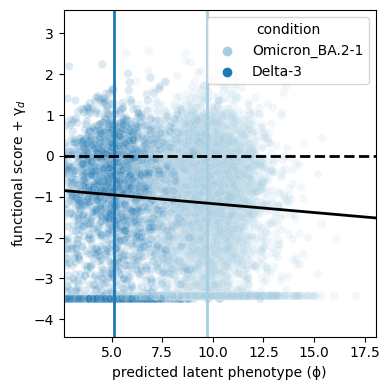

In [22]:
fig, ax = plt.subplots(figsize=[4,4])
a_model_object.plot_epistasis(ax=ax, alpha=0.15, show=False)
plt.show()

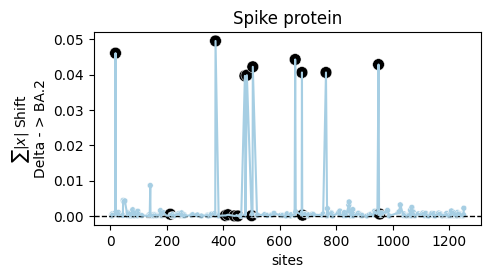

In [23]:
fig, ax = plt.subplots(figsize=[5,2.5])
agg_func = lambda x: onp.abs(onp.mean(onp.sum(x)))
a_model_object.plot_shifts_by_site(ax=ax, condition="Omicron_BA.2-1", agg_func=agg_func, show=False)
ax.set_ylabel("$\sum |x|$ Shift\nDelta - > BA.2")
ax.set_title("Spike protein")
plt.show()

We offer the ability to interactively visualize a model's shift parameters using the `MultiDmsModel.mut_shift_plot()` method which wraps the original viz function from `polyclonal.plot.lineplot_and_heatmap()` as seen [here](https://github.com/jbloomlab/polyclonal/blob/92fee4badb14e1db719074f202b4fab374dd0613/polyclonal/plot.py#L263) 

**NOTE:** Currently, the heatmaps place an "X" at the wildtype for the reference sequence _only_. Note that you quite easily look up the wildtypes for any homolog at a given site using the `MultiDmdData.site_map` property.

In [24]:
data.non_identical_sites

frozendict.frozendict({'Omicron_BA.2-1': array([440, 477, 417, 655, 405,  27, 493, 679, 950, 969, 213, 954, 452,
       371, 376, 681, 408, 501, 796, 375, 484, 373, 156, 339, 498,  19,
       764, 505]), 'Delta-3': []})

In [25]:
chart = a_model_object.mut_shift_plot()
chart

/home/jared/miniconda3/envs/multidms-toml/lib/python3.9/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [ ]:
# chart.save("ref-delta-3-sigmoid.html")